# **Loading data and packages**

**Libraries import**

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from joblib import load, dump

from sklearn.model_selection import (
    train_test_split, LeaveOneOut, cross_validate, learning_curve, cross_val_predict
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import geometric_mean_score
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

**Data import**

In [10]:
# Path to the CSV file containing the DataFrame
combined_data_file = '..\\datasets\\df_combined.csv'

# Loading the DataFrame directly from the CSV file
df_combined = pd.read_csv(combined_data_file)

# Renaming columns from Portuguese to English
df_combined.rename(columns={
    'Sexo': 'Gender',
    'Idade': 'Age',
    'MBL-550': 'MBL-550',
    'MBL -221': 'MBL -221',
    'MBL EXON': 'MBL EXON',
    'Sintomas urinários': 'Urinary symptoms',
    'Dor': 'Pain',
    'Transtorno/sintomas neurológicos': 'Neurological disorders/symptoms'
}, inplace=True)

# Normalizando apenas a coluna "Idade"
scaler = MinMaxScaler()
df_combined['Age'] = scaler.fit_transform(df_combined[['Age']])

y = df_combined['HAM/TSP']  # Target variable
X = df_combined.drop('HAM/TSP', axis=1)  # Predictor variables

# Displaying the first rows of the DataFrame with the “Age” column normalized
display(df_combined.head())


,Gender,Age,MBL-550,MBL -221,MBL EXON,Urinary symptoms,Pain,Neurological disorders/symptoms,HAM/TSP
0,0,0.758621,1,0,2,2,4,5,0
1,1,0.137931,0,0,1,0,0,0,0
2,0,0.517241,2,1,0,0,0,0,0
3,0,0.206897,1,0,0,0,0,0,0
4,0,0.293103,1,1,1,0,0,0,0


#  **Definition of variables, models and metrics**

**Define the variables (X and y) and classifiers** 

In [11]:
# List of model names that have been adjusted
model_names = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AdaBoost', 'LSVM']

# Directory where models and results are saved
model_dir = '..\\models\\'

# Dictionary to store loaded templates
classifiers = {}

# Function for loading templates
def load_model(model_name):
    model_path = os.path.join(model_dir, f'best_{model_name}_model.joblib')

    if os.path.exists(model_path):
        # Load the model
        model = load(model_path)

        
        if isinstance(model, SVC):
            model.probability = True

        # Add the model to the classifiers dictionary using the corresponding name
        classifiers[model_name] = model

        print(f'Modelo {model_name} carregado com sucesso.')
    else:
        print(f'Arquivo para o modelo {model_name} não encontrado.')

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AdaBoost carregado com sucesso.
Modelo LSVM carregado com sucesso.


# **Model evaluation**

In [12]:
# List to store results
results = []

# Define the Leave-One-Out strategy
loo = LeaveOneOut()

# Iterating over classifiers
for clf_name, clf in classifiers.items():
    
    # Define the pipeline
    pipeline = Pipeline([
        ('undersampler', RandomUnderSampler(random_state=42)),  # Balancing
        ('classifier', clf)  # Classifier
    ])
    
    # Perform Leave-One-Out predictions
    y_pred = cross_val_predict(pipeline, X, y, cv=loo)
    
    # Handle classifiers that do not support predict_proba
    try:
        y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='predict_proba')[:, 1]
    except AttributeError:
        if hasattr(clf, "decision_function"):
            y_prob = cross_val_predict(pipeline, X, y, cv=loo, method='decision_function')
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Scale to [0, 1] range
        else:
            y_prob = np.zeros_like(y_pred)  # Handle classifiers with no probability/decision function

    # Calculate test metrics
    test_scores = {
        'classifier': clf_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'ROC AUC': roc_auc_score(y, y_prob),
        'G-Mean': geometric_mean_score(y, y_pred)
    }

    # Add to results list
    results.append(test_scores)

# Convert results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


  classifier  Accuracy  Precision    Recall        F1   ROC AUC    G-Mean
0         DT  0.921569   0.800000  0.740741  0.769231  0.734862  0.843413
1         GB  0.915033   0.769231  0.740741  0.754717  0.866255  0.839921
2         LR  0.843137   0.540541  0.740741  0.625000  0.840682  0.800500
3        MLP  0.856209   0.560976  0.851852  0.676471  0.912698  0.854493
4         NB  0.901961   0.750000  0.666667  0.705882  0.856408  0.796819
5         RF  0.836601   0.529412  0.666667  0.590164  0.858319  0.762896
6        SVM  0.843137   0.536585  0.814815  0.647059  0.858319  0.831833
7        KNN  0.830065   0.513514  0.703704  0.593750  0.808789  0.776643
8   AdaBoost  0.915033   0.791667  0.703704  0.745098  0.844503  0.822058
9       LSVM  0.901961   0.730769  0.703704  0.716981  0.860376  0.815236


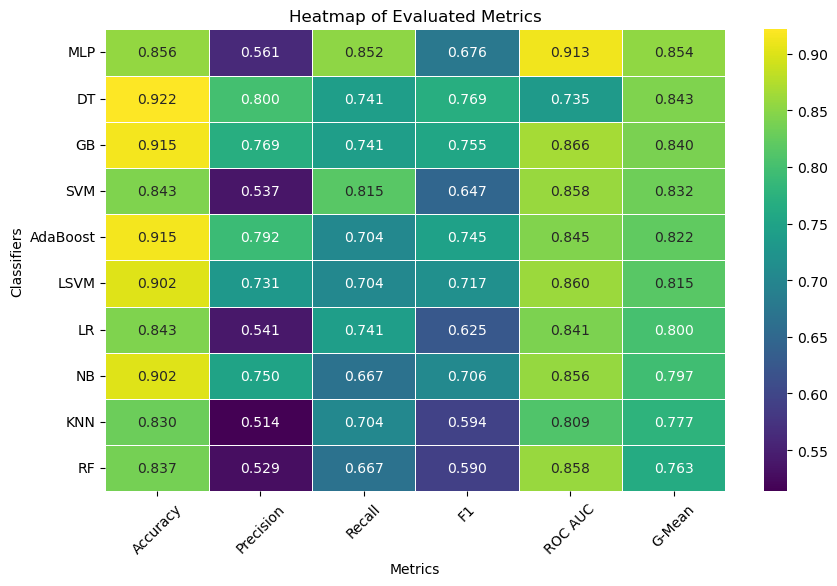

In [13]:
# Definindo os nomes das métricas de avaliação
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'G-Mean']

# Selecionando as métricas para o heatmap e configurando o índice
heatmap_df = results_df[metric_names].set_index(results_df['classifier'])

# Ordenando o DataFrame pelo valor do G-Mean
heatmap_df = heatmap_df.sort_values(by='G-Mean', ascending=False)

# Plotando o heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".3f", linewidths=.5)
plt.title('Heatmap of Evaluated Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classifiers')
plt.xticks(rotation=45)
plt.savefig('..\\results\\heatmap.jpeg')
plt.show()


In [14]:
# Instantiating RandomUnderSampler
rus = RandomUnderSampler()

# Apply RandomUnderSampler to data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Creating a new DataFrame with the resampled data
df_ = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['HAM/TSP'])], axis=1)

y = df_['HAM/TSP']  # Target variable
X = df_.drop('HAM/TSP', axis=1)  # Predictor variables

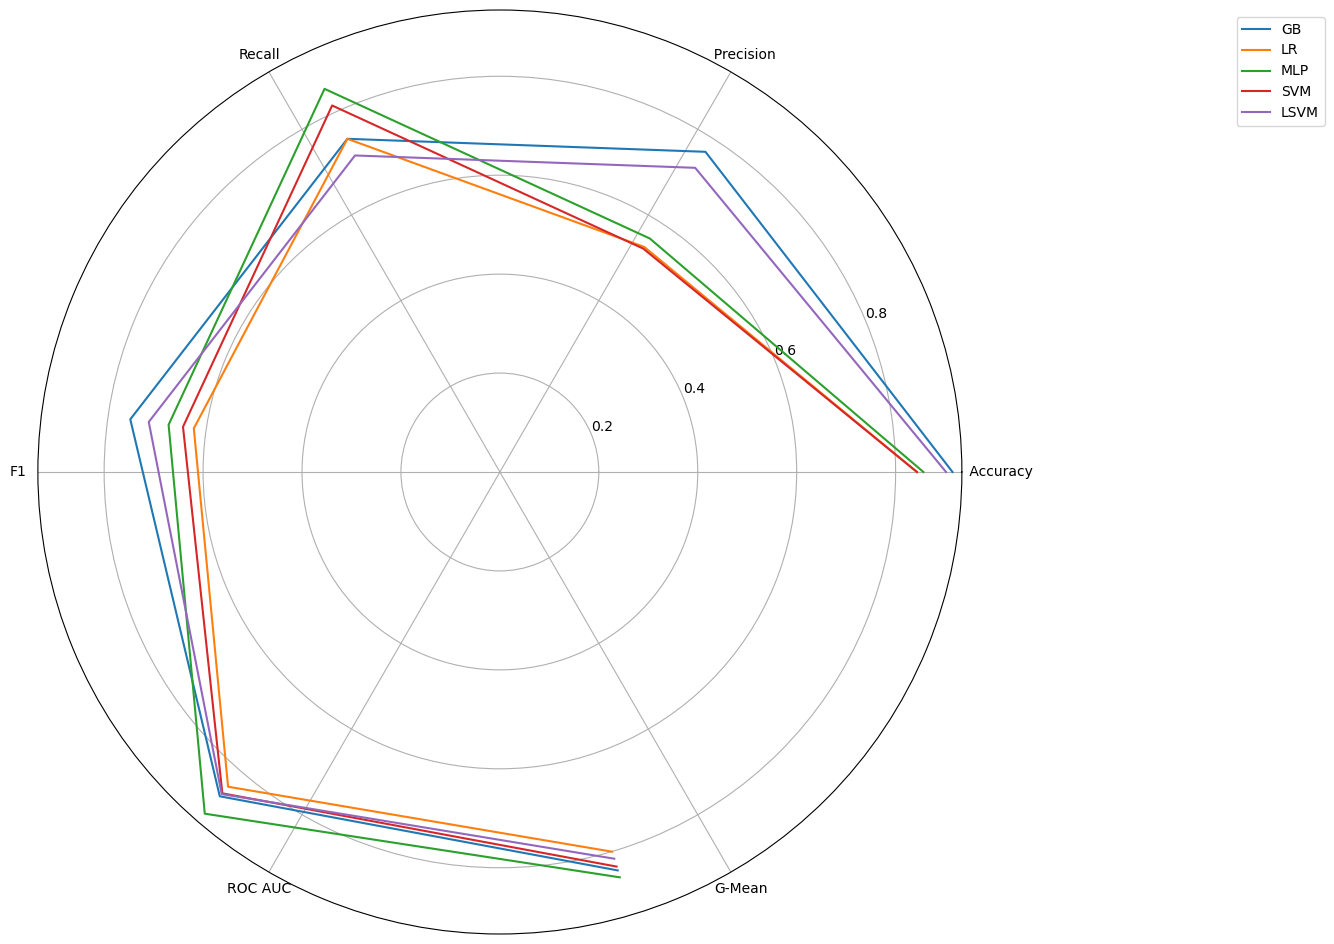

In [15]:
# Polar plot
clean_models = ['GB', 'LR', 'MLP', 'SVM', 'LSVM']
results_df = results_df[results_df['classifier'].isin(clean_models)]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})

for i, row in results_df.iterrows():
    ax.plot([row['Accuracy'], row['Precision'], row['Recall'], row['F1'], row['ROC AUC'], row['G-Mean']], label=row['classifier'])

ax.set_xticks(np.linspace(0, 2*np.pi, 6, endpoint=False))
ax.set_xticklabels(['         Accuracy', 
                    '  Precision', 'Recall', 
                    'F1', 'ROC AUC', 'G-Mean'])
ax.set_ylabel('')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
ax.set_prop_cycle(color=plt.cm.viridis(np.linspace(0, 1, len(results_df))))
plt.show()

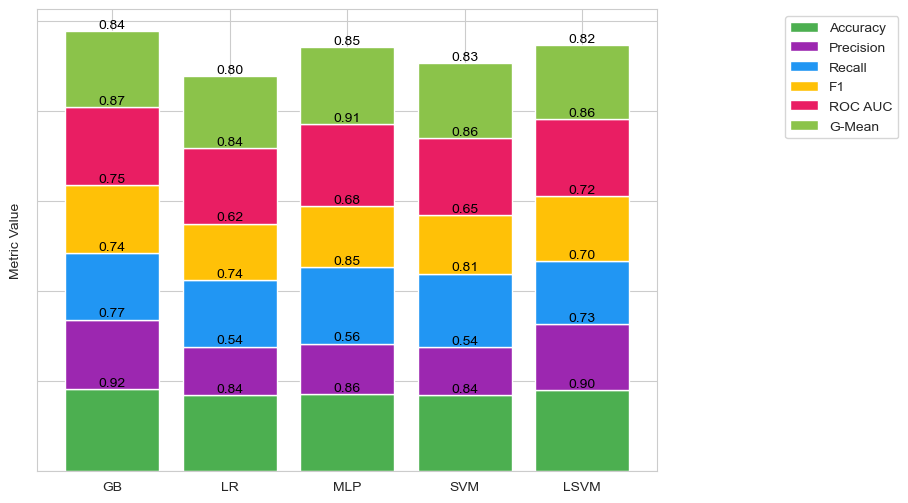

In [16]:
# Barplot to compare the metrics
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(range(len(results_df)), results_df['Accuracy'], label='Accuracy', color='#4CAF50')  # Green
for i, (bar, value) in enumerate(zip(bars, results_df['Accuracy'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Precision'], bottom=results_df['Accuracy'], label='Precision', color='#9C27B0')  # Purple
for i, (bar, value) in enumerate(zip(bars, results_df['Precision'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + results_df['Accuracy'].iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['Recall'], bottom=results_df['Accuracy'] + results_df['Precision'], label='Recall', color='#2196F3')  # Blue
for i, (bar, value) in enumerate(zip(bars, results_df['Recall'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['F1'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'], label='F1', color='#FFC107')  # Yellow
for i, (bar, value) in enumerate(zip(bars, results_df['F1'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['ROC AUC'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'], label='ROC AUC', color='#E91E63')  # Pink
for i, (bar, value) in enumerate(zip(bars, results_df['ROC AUC'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

bars = ax.bar(range(len(results_df)), results_df['G-Mean'], bottom=results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC'], label='G-Mean', color='#8BC34A')  # Light Green
for i, (bar, value) in enumerate(zip(bars, results_df['G-Mean'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (results_df['Accuracy'] + results_df['Precision'] + results_df['Recall'] + results_df['F1'] + results_df['ROC AUC']).iloc[i], f"{value:.2f}", ha='center', va='bottom', color='black')

ax.set_xticks(range(len(results_df)))
ax.set_yticklabels([])
ax.set_xticklabels(results_df['classifier'])
ax.set_ylabel('Metric Value')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

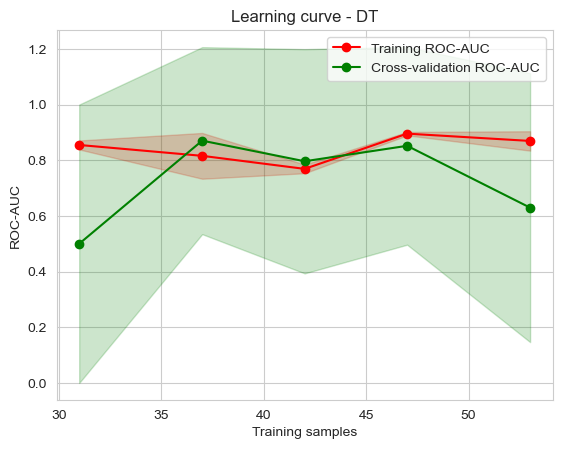

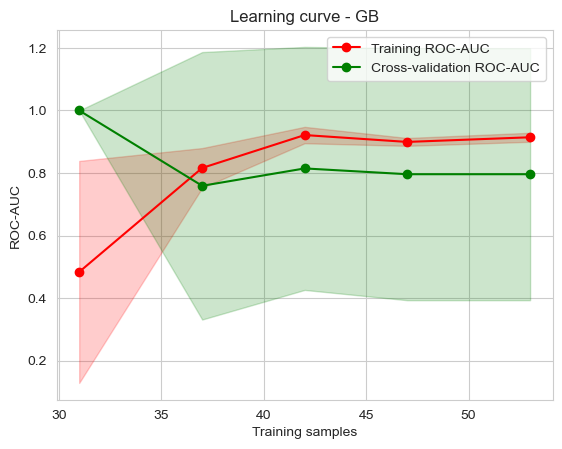

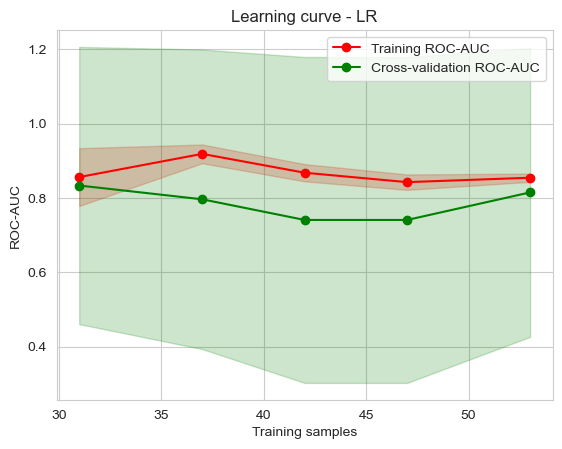

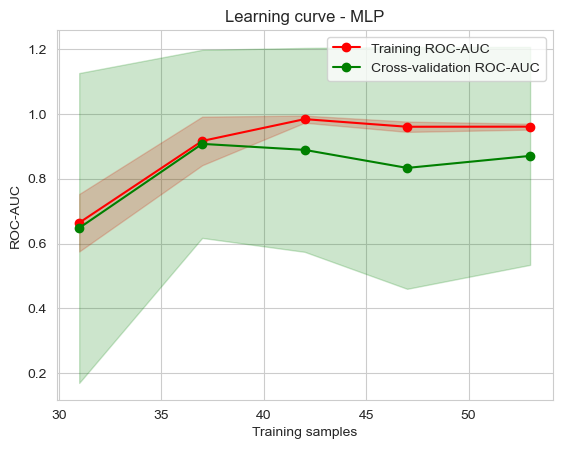

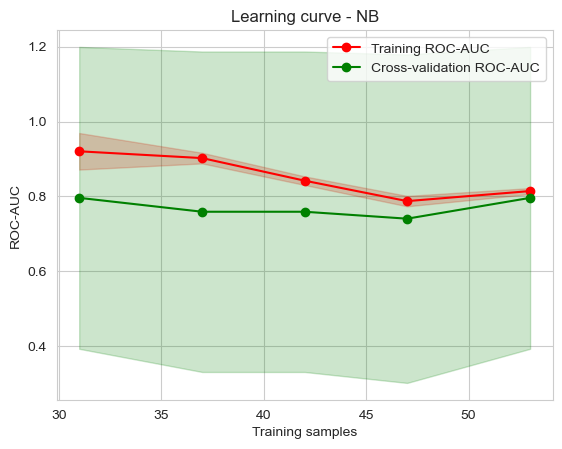

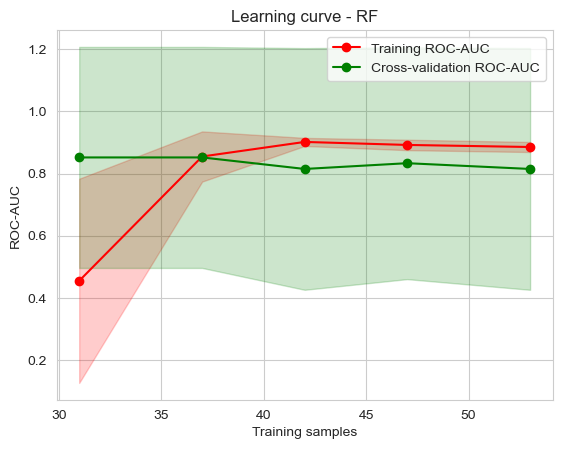

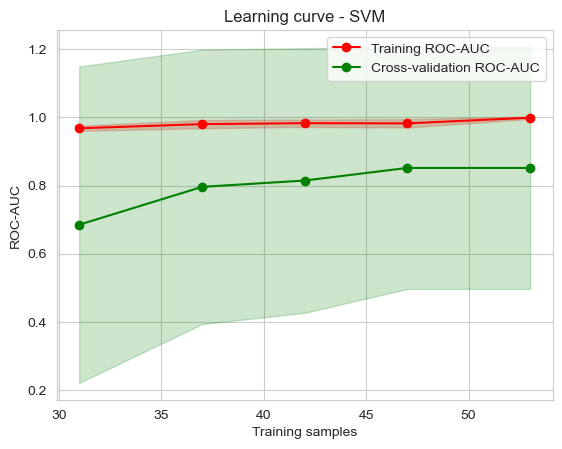

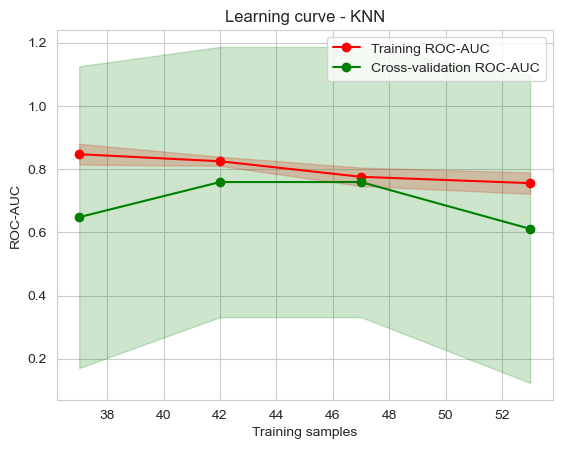

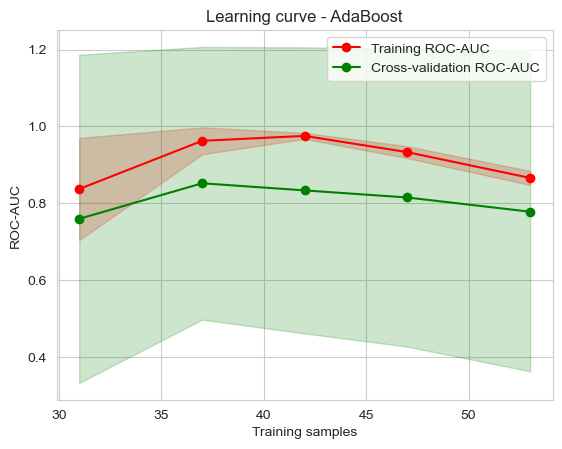

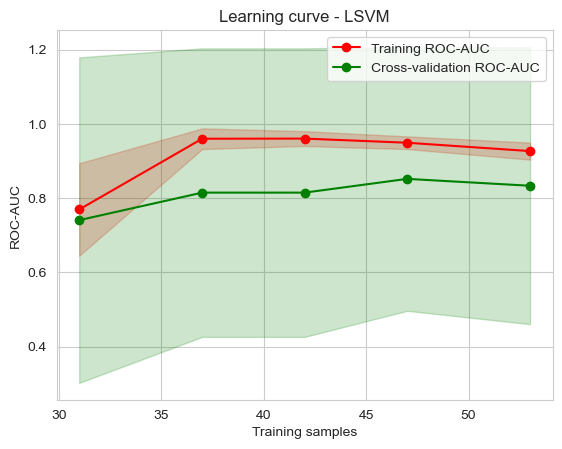

In [17]:
# Function to plot learning curves with shaded areas for standard deviation
def plot_learning_curve(X, y, classifiers, train_sizes=np.linspace(0.1, 1.0, 10)):
    results_dir = '..\\results\\'  # Adjust the directory path if needed
    for name, estimator in classifiers.items():
        # Get learning curve data
        train_sizes_abs, train_scores, test_scores = learning_curve(
            estimator, X, y, train_sizes=train_sizes, cv=loo, scoring='accuracy', n_jobs=-1
        )

        # Calculate means and standard deviations
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot the learning curves
        plt.figure()
        plt.title(f'Learning curve - {name}')
        plt.xlabel("Training samples")
        plt.ylabel("ROC-AUC")

        # Plot training data and fill between for standard deviation
        plt.plot(train_sizes_abs, train_scores_mean, 'o-', label="Training ROC-AUC", color="r")
        plt.fill_between(train_sizes_abs, 
                         train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, 
                         alpha=0.2, color="r")  # Shadow for training

        # Plot test data and fill between for standard deviation
        plt.plot(train_sizes_abs, test_scores_mean, 'o-', label="Cross-validation ROC-AUC", color="g")
        plt.fill_between(train_sizes_abs, 
                         test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, 
                         alpha=0.2, color="g")  # Shadow for cross-validation

        # Show legend and grid
        plt.legend(loc="best")
        plt.grid(True)

        # Save the plot
        plot_filename = os.path.join(results_dir, f'curva_aprendizado_{name}.png')
        plt.savefig(plot_filename)
        plt.show()

# Example usage: Call the plot_learning_curve function with your data
plot_learning_curve(X, y, classifiers)


Modelo DT carregado com sucesso.
Modelo GB carregado com sucesso.
Modelo LR carregado com sucesso.
Modelo MLP carregado com sucesso.
Modelo NB carregado com sucesso.
Modelo RF carregado com sucesso.
Modelo SVM carregado com sucesso.
Modelo KNN carregado com sucesso.
Modelo AdaBoost carregado com sucesso.
Modelo LSVM carregado com sucesso.


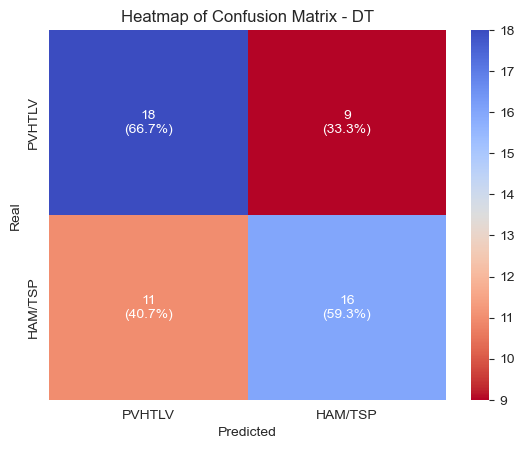

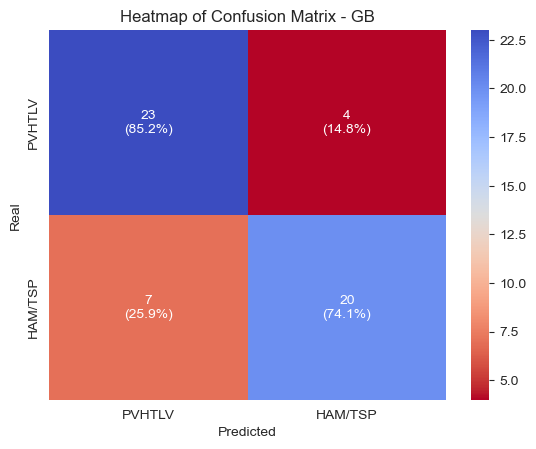

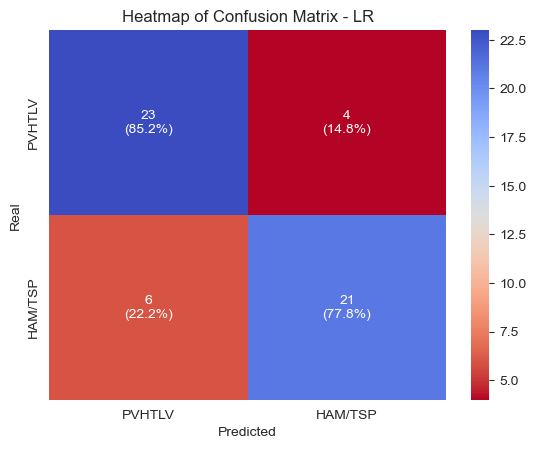

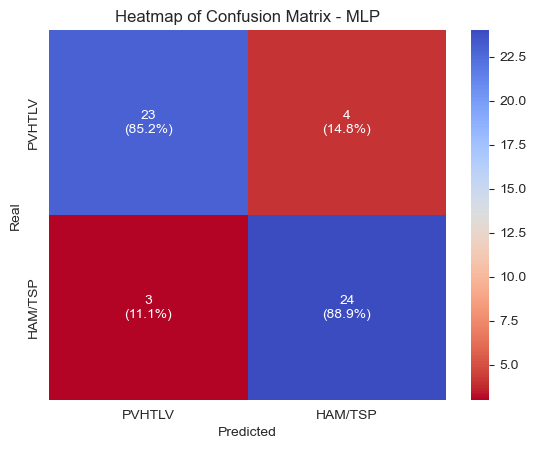

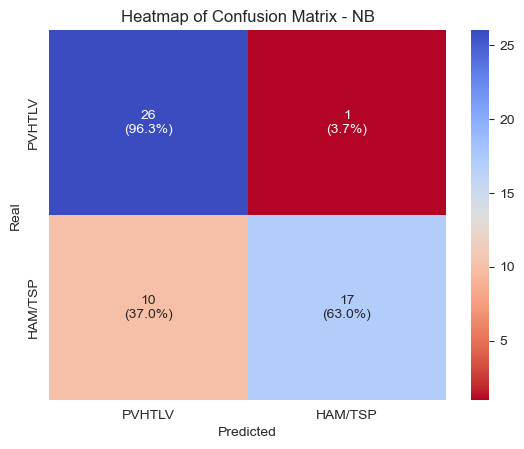

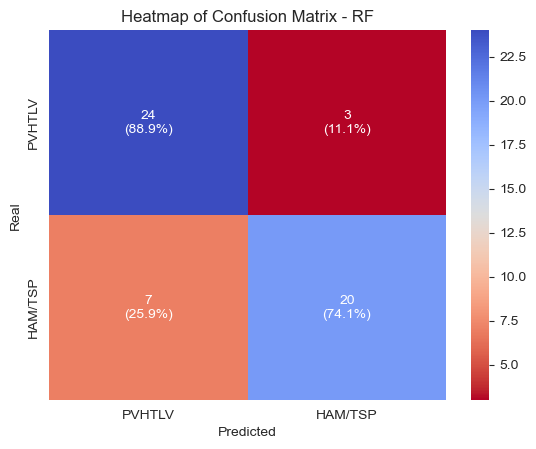

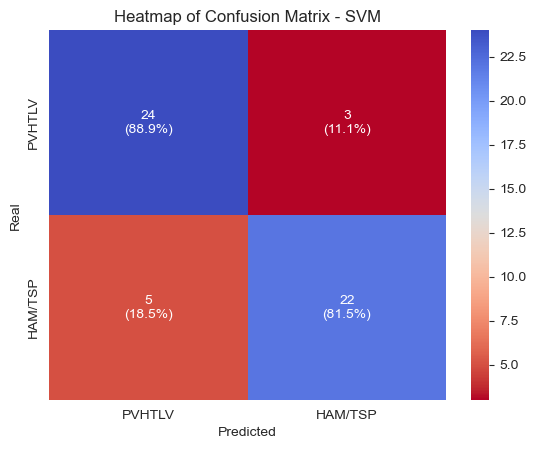

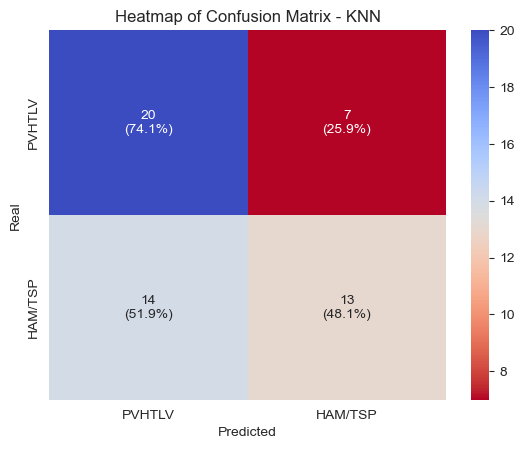

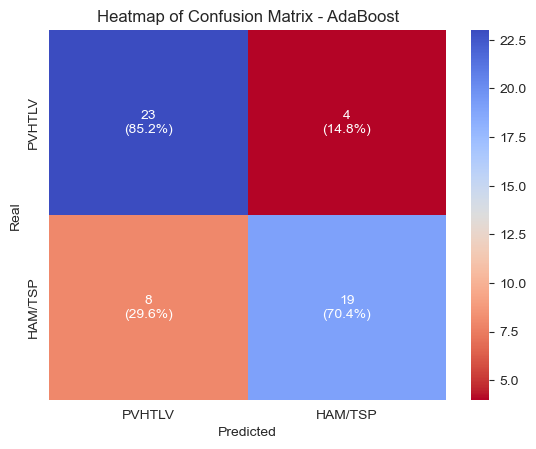

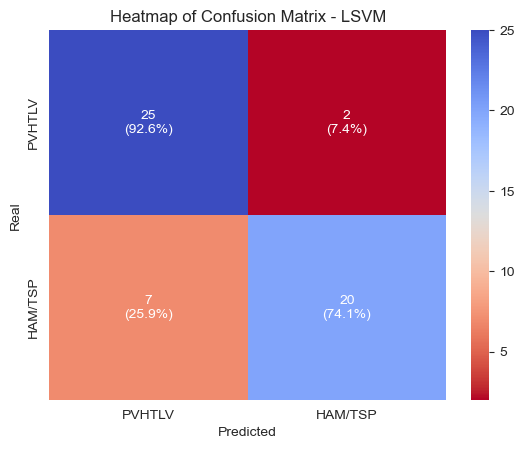

{'DT': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.08373883555532845,
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=5, min_samples_split=9,
                                        random_state=42))]), 'GB': Pipeline(steps=[('normalization', MinMaxScaler()),
                ('balancing', RandomUnderSampler(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.010168587136004645,
                                            max_depth=8, min_samples_leaf=6,
                                            min_samples_split=12,
                                            n_estimators=174, random_state=42,
                                            subsample=0.6210749589588561))]), 'LR': Pipeline(steps

In [18]:

# Function to plot confusion matrix with percentages per row
def plot_confusion_matrix(model_name, X, y, loo):
    model = classifiers[model_name]
    
    # Making predictions using cross_val_predict
    y_preds = cross_val_predict(model, X, y, cv=loo)
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y, y_preds)
    
    # Convert confusion matrix to percentages per row
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percent = np.nan_to_num(cm_percent)  # Handle divisions by zero
    
    # Define custom labels
    labels = ['PVHTLV', 'HAM/TSP']

    # Create annotations combining absolute values and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot the heat map
    sns.heatmap(cm, annot=annot, fmt='', cmap='coolwarm_r', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(f'Heatmap of Confusion Matrix - {model_name}')
    
    # Save the picture
    plt.savefig(f'../results/{model_name}_confusion_matrix.jpeg')
    plt.show()

# Iterate over all the model names and load them
for model_name in model_names:
    load_model(model_name)

# Example: Assume X, y, and loo are already defined as your dataset and cross-validation strategy
# You can now plot the confusion matrix for each model
for model_name in model_names:
    if model_name in classifiers:  # Only plot if the model is loaded successfully
        plot_confusion_matrix(model_name, X, y, loo)

# Print the classifiers dictionary to verify if models were loaded successfully
print(classifiers)
